In [1]:
%matplotlib notebook

In [2]:
from astropy import units as u
import matplotlib.pyplot as plt
import numpy as np

from ctapipe.io.hessio import hessio_event_source
from ctapipe.visualization import CameraDisplay
from ctapipe.instrument.camera import CameraGeometry
from ctapipe.calib import CameraCalibrator
from ctapipe.reco.HillasReconstructor import HillasReconstructor
from ctapipe.image.hillas import hillas_parameters
from ctapipe.image.cleaning import tailcuts_clean
from ctapipe.utils import linalg
from ctapipe.utils import datasets

In [3]:
# path to MC dataset
%env CTAPIPE_SVC_PATH=/Users/jer/DATA/MAGIC/prod3blp_sample

env: CTAPIPE_SVC_PATH=/Users/jer/DATA/MAGIC/prod3blp_sample


In [4]:
# MC dataset
filename = datasets.get_dataset(
    "gamma_20deg_0deg_run102___cta-prod3-lapalma3-2147m-LaPalma.simtel.gz")

In [5]:
# get source events in MC dataset
source = hessio_event_source(filename, allowed_tels={1, 2, 3, 4})

In [6]:
# for each event
off_angles = []      

reco = HillasReconstructor()
calib = CameraCalibrator(None, None)

In [7]:
for event in source:

    # shower direction
    # converting MC shower angular parameters to 3D spatial vector
    shower_azimuth = event.mc.az                        # same as in MC file
    shower_altitude = np.pi * u.rad / 2 - event.mc.alt  # altitude = 90 - mc.alt
    shower_direction = linalg.set_phi_theta(shower_azimuth, shower_altitude)

    # calibrating the event
    calib.calibrate(event)

    # for each telescope and event
    point_azimuth = {}
    point_altitude = {}
    hillas_params = {}

    # get hillas params for each event in different telescopes
    for tel_id in event.dl0.tels_with_data:

        # telescope pointing direction extracted from MC dataset
        point_azimuth[tel_id] = event.mc.tel[tel_id].azimuth_raw * u.rad
        point_altitude[tel_id] = (
            np.pi / 2 - event.mc.tel[tel_id].altitude_raw) * u.rad

        # camera geometry required for hillas parametrization
        pix_x, pix_y = event.inst.pixel_pos[tel_id]
        foclen = event.inst.optical_foclen[tel_id]
        camgeom = CameraGeometry.guess(pix_x, pix_y, foclen)

        # note that [0] is for channel 0 which is high-gain channel
        image = event.dl1.tel[tel_id].image[0]

        # cleaning  the image
        cleaned_image = image
        # create a clean mask of pixels above the threshold
        cleanmask = tailcuts_clean(
            camgeom, image, picture_thresh=10, boundary_thresh=5)
        # set all rejected pixels to zero
        cleaned_image[~cleanmask] = 0

        # calulate hillas parameters
        # it fails for empty pixels
        try:
            hillas_params[tel_id] = hillas_parameters(camgeom, cleaned_image)
        except:
            pass

    # not a stereo event -> next event
    if len(hillas_params) < 2:
        continue

    # fit stereo event direction
    reco.get_great_circles(
        hillas_params, event.inst.subarray, point_azimuth, point_altitude)
    
    # reconstruct direction (3 components) with errors on the values
    reco_direction, reco_dir_err = reco.fit_origin_crosses()

    # in case fit reconstruct fails to get any real value -> next event
    if np.isnan(reco_direction).any():
        continue

    # get angular offset between reconstructed event direction and MC shower direction
    off_angle = linalg.angle(reco_direction, shower_direction)

    # appending all estimated off angles of each event
    off_angles.append(off_angle.to(u.deg).value)

/Users/jer/git/ctapipe/ctapipe/image/hillas.py:705: RuntimeWarning: invalid value encountered in sqrt
  width = np.sqrt((vy2 + vx2 - z) / 2.0)
/Users/jer/anaconda/envs/cta-dev/lib/python3.5/site-packages/astropy/units/quantity.py:957: RuntimeWarning: divide by zero encountered in true_divide
  return super(Quantity, self).__truediv__(other)
/Users/jer/git/ctapipe/ctapipe/image/hillas.py:714: RuntimeWarning: invalid value encountered in sqrt
  miss = np.sqrt((uu * xm2 + vv * ym2) / 2.0 - xmym * (2.0 * vxy / z))
/Users/jer/git/ctapipe/ctapipe/utils/linalg.py:71: RuntimeWarning: invalid value encountered in true_divide
  return vec / length(vec)


In [8]:
# square the angles
thetasq = []
for i in off_angles:
    thetasq.append(i**2)

<IPython.core.display.Javascript object>


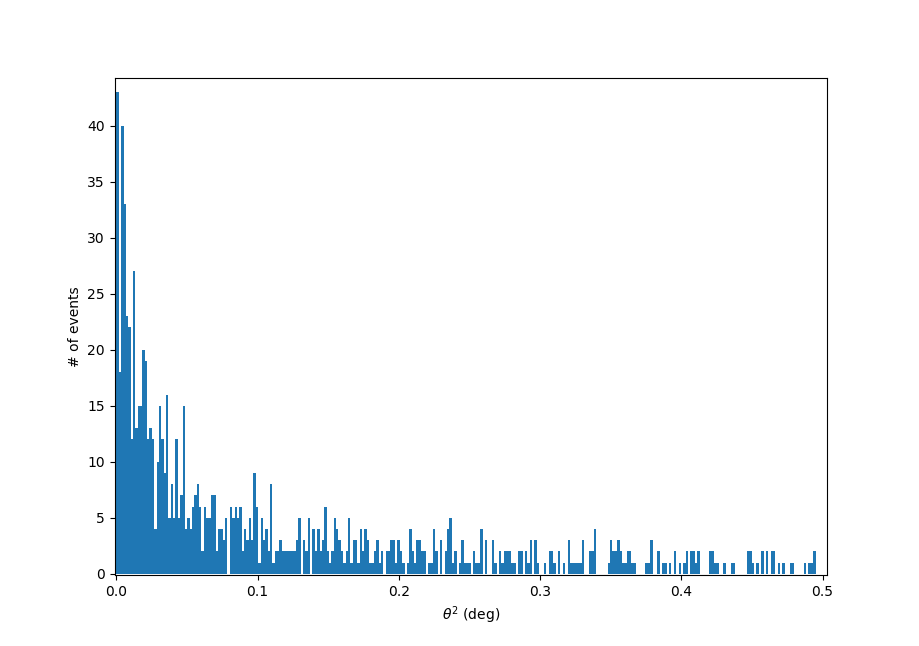

In [9]:
# plot 
plt.hist(thetasq, bins=np.linspace(0, 0.5, 300))
plt.xlabel(r'$\theta^2$ (deg)')
plt.ylabel("# of events")
plt.show()